In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
from PIL import Image
from tqdm import tqdm

sys.path.append('..')
from src.data import create_dataloaders, denormalize

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.models as models


In [2]:
# Load config
with open('../experiments/configs/baseline_config.json', 'r') as f:
    CONFIG = json.load(f)

device = torch.device(CONFIG['device'])

# Load data
train_loader, val_loader, dataset = create_dataloaders(
    data_root=CONFIG['data']['data_root'],
    split_metadata_path=CONFIG['data']['split_metadata_path'],
    batch_size=32,
    num_workers=4,
    img_size=224,
    pin_memory=False
)
val_dataset = val_loader.dataset

print(f"✓ Validation dataset: {len(val_dataset)} samples")


✓ Loaded split from ../data/processed/split_metadata.json
✓ Train dataset: 2944 samples
✓ Val dataset: 736 samples
✓ Train loader: 92 batches
✓ Val loader: 23 batches
✓ Validation dataset: 736 samples


In [3]:
# Load model and weights
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, CONFIG['num_classes'])
model.load_state_dict(torch.load('../models/checkpoints/baseline/resnet50_best.pth', map_location=device)['model_state_dict'])
model = model.to(device).eval()
print("✓ Baseline model loaded")


✓ Baseline model loaded


In [8]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def compute_far(cam, mask):
    # cam: (H, W), mask: (H, W), mask==1 is foreground
    foreground = cam[mask == 1].sum()
    total = cam.sum()
    return float(foreground / total) if total > 0 else 0

def get_normalized_cam(input_tensor, model, target_layer, class_idx):
    cam_extractor = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam_extractor(input_tensor=input_tensor.unsqueeze(0), targets=[ClassifierOutputTarget(class_idx)])[0]
    cam_norm = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam) + 1e-8)
    return cam_norm


In [13]:
target_layer = model.layer4[-1]

# Option 1: Use ALL 736 validation images (recommended for comprehensive analysis)
n_samples = len(val_dataset)  # 736 images
sample_indices = list(range(n_samples))

# Option 2: Use random sample if you want faster results (e.g., 200 images)
# n_samples = 200
# np.random.seed(42)
# sample_indices = np.random.choice(len(val_dataset), n_samples, replace=False)

far_scores = []
examples = []

output_dir = '../experiments/results/gradcam/baseline'
os.makedirs(output_dir, exist_ok=True)

print(f"Computing FAR for {n_samples} validation images...")

for i, idx in enumerate(tqdm(sample_indices)):
    sample = val_dataset[idx]
    image = sample['original_image'] / 255.0  # Normalize to [0,1]
    mask = (sample['original_mask'] == 1).astype(np.uint8)
    label = sample['label']
    class_name = dataset.classes[label]

    # Prepare input tensor with ImageNet normalization
    input_tensor = torch.tensor(image.transpose(2, 0, 1)).float()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    input_tensor = (input_tensor - mean) / std
    input_tensor = input_tensor.to(device)

    # Get prediction
    with torch.no_grad():
        output = model(input_tensor.unsqueeze(0))
        pred_cls = output.argmax(dim=1).item()
        pred_name = dataset.classes[pred_cls]

    # Generate Grad-CAM
    cam = get_normalized_cam(input_tensor, model, target_layer, pred_cls)

    # Compute FAR
    far = compute_far(cam, mask)
    far_scores.append(far)
    
    # Store example
    examples.append({
        'idx': idx,
        'true_class': class_name,
        'pred_class': pred_name,
        'correct': (label == pred_cls),
        'far': far,
        'cam': cam,
        'image': image,
        'mask': mask,
    })

    # Save visualization for first 50 samples (or all if you want)
    if i < 50:
        cam_vis = show_cam_on_image(image, cam, use_rgb=True)
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        axes[0].imshow(image)
        axes[0].set_title(f'Original\n{class_name}')
        axes[0].axis('off')
        
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Segmentation Mask\n(1=pet, 0=bg)')
        axes[1].axis('off')
        
        axes[2].imshow(cam, cmap='jet')
        axes[2].set_title(f'Grad-CAM Heatmap\nFAR={far:.2f}')
        axes[2].axis('off')
        
        axes[3].imshow(cam_vis)
        axes[3].set_title(f'Overlay\nPred: {pred_name}')
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/sample_{i:03d}_idx{idx:04d}.png", dpi=100)
        plt.close()

far_scores = np.array(far_scores)
print(f"\n✓ Computed FAR for {len(far_scores)} images")
print(f"  Mean FAR: {far_scores.mean():.3f}")
print(f"  Median FAR: {np.median(far_scores):.3f}")
print(f"  Std FAR: {far_scores.std():.3f}")


Computing FAR for 736 validation images...


100%|███████████████████████████████████████████████████████████████████| 736/736 [00:45<00:00, 16.23it/s]


✓ Computed FAR for 736 images
  Mean FAR: 0.666
  Median FAR: 0.680
  Std FAR: 0.178


FOREGROUND ATTENTION RATIO (FAR) ANALYSIS
Total samples analyzed: 736

FAR Statistics:
  Mean:   0.666
  Median: 0.680
  Std:    0.178
  Min:    0.000
  Max:    0.998

Percentiles:
  10th: 0.429
  25th: 0.555
  50th: 0.680
  75th: 0.798
  90th: 0.896

FAR Distribution:
  Low FAR (<0.3):       16 (2.2%) - Background-focused
  Medium FAR (0.3-0.6): 240 (32.6%) - Mixed attention
  High FAR (>0.6):      480 (65.2%) - Foreground-focused


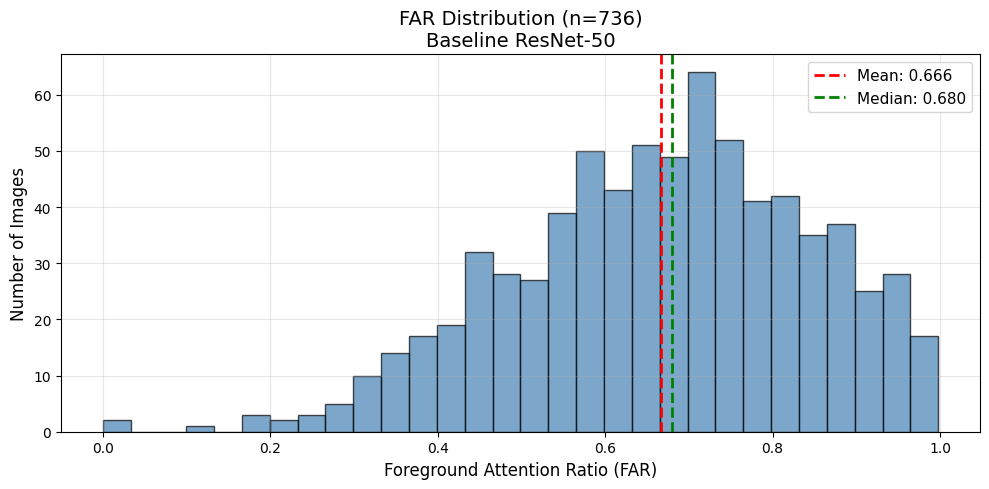

In [15]:
# Statistical summary
print("="*60)
print("FOREGROUND ATTENTION RATIO (FAR) ANALYSIS")
print("="*60)
print(f"Total samples analyzed: {len(far_scores)}")
print(f"\nFAR Statistics:")
print(f"  Mean:   {far_scores.mean():.3f}")
print(f"  Median: {np.median(far_scores):.3f}")
print(f"  Std:    {far_scores.std():.3f}")
print(f"  Min:    {far_scores.min():.3f}")
print(f"  Max:    {far_scores.max():.3f}")
print(f"\nPercentiles:")
print(f"  10th: {np.percentile(far_scores, 10):.3f}")
print(f"  25th: {np.percentile(far_scores, 25):.3f}")
print(f"  50th: {np.percentile(far_scores, 50):.3f}")
print(f"  75th: {np.percentile(far_scores, 75):.3f}")
print(f"  90th: {np.percentile(far_scores, 90):.3f}")

# Categorize samples by FAR
low_far = far_scores < 0.3
medium_far = (far_scores >= 0.3) & (far_scores < 0.6)
high_far = far_scores >= 0.6

print(f"\nFAR Distribution:")
print(f"  Low FAR (<0.3):      {low_far.sum():3d} ({low_far.sum()/len(far_scores)*100:.1f}%) - Background-focused")
print(f"  Medium FAR (0.3-0.6): {medium_far.sum():3d} ({medium_far.sum()/len(far_scores)*100:.1f}%) - Mixed attention")
print(f"  High FAR (>0.6):      {high_far.sum():3d} ({high_far.sum()/len(far_scores)*100:.1f}%) - Foreground-focused")

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(far_scores, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(far_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {far_scores.mean():.3f}')
plt.axvline(np.median(far_scores), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(far_scores):.3f}')
plt.xlabel('Foreground Attention Ratio (FAR)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title(f'FAR Distribution (n={len(far_scores)})\nBaseline ResNet-50', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_dir}/far_histogram.png", dpi=150)
plt.show()

print("\n" + "="*60)


In [16]:
# Analyze FAR per class
import pandas as pd

per_class_far = {}
for e in examples:
    cls = e['true_class']
    if cls not in per_class_far:
        per_class_far[cls] = []
    per_class_far[cls].append(e['far'])

# Create per-class summary
class_summary = []
for cls, far_list in per_class_far.items():
    class_summary.append({
        'class': cls,
        'count': len(far_list),
        'mean_far': np.mean(far_list),
        'std_far': np.std(far_list),
        'min_far': np.min(far_list),
        'max_far': np.max(far_list)
    })

class_df = pd.DataFrame(class_summary).sort_values('mean_far')

print("PER-CLASS FAR ANALYSIS")
print("="*60)
print("\n10 Classes with LOWEST FAR (most background-dependent):")
print(class_df.head(10).to_string(index=False))

print("\n10 Classes with HIGHEST FAR (most foreground-focused):")
print(class_df.tail(10).to_string(index=False))

# Save per-class analysis
class_df.to_csv(f"{output_dir}/per_class_far.csv", index=False)
print(f"\n✓ Per-class FAR saved to {output_dir}/per_class_far.csv")


PER-CLASS FAR ANALYSIS

10 Classes with LOWEST FAR (most background-dependent):
                    class  count  mean_far  std_far  min_far  max_far
                   Beagle     15  0.486368 0.199640 0.121802 0.876980
       German Shorthaired     16  0.509902 0.183052 0.235086 0.953619
             Egyptian Mau     23  0.539350 0.122840 0.342038 0.802135
American Pit Bull Terrier     17  0.550334 0.115659 0.321840 0.764609
               Abyssinian     18  0.572552 0.127043 0.274141 0.773276
                Chihuahua     23  0.576064 0.148966 0.320592 0.886254
           English Setter     15  0.584699 0.110700 0.328517 0.749207
       Miniature Pinscher     16  0.589518 0.105746 0.434302 0.724176
                    Boxer     22  0.590654 0.192160 0.166571 0.946271
                Shiba Inu     19  0.599085 0.188836 0.202822 0.828402

10 Classes with HIGHEST FAR (most foreground-focused):
            class  count  mean_far  std_far  min_far  max_far
              Pug     19  0.7221

Creating gallery of LOW FAR examples (proves spurious correlation)...


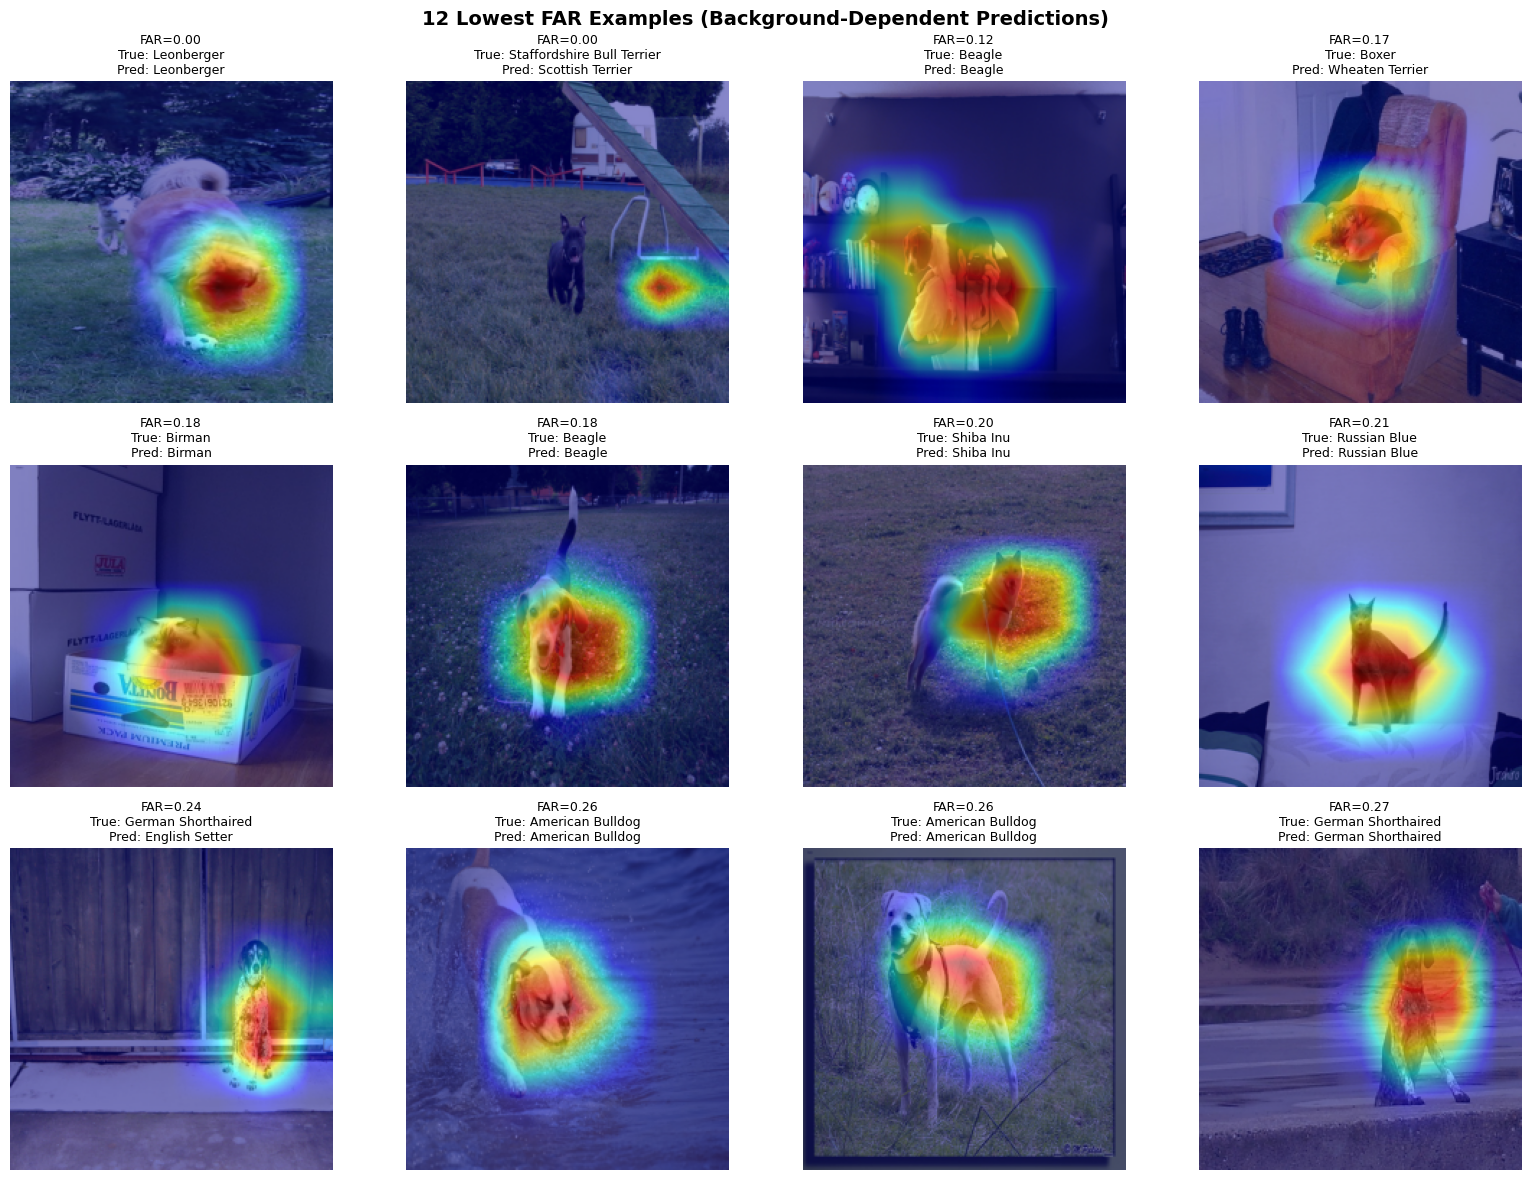

✓ Low FAR gallery saved


In [17]:
# Sort all examples by FAR
sorted_examples = sorted(examples, key=lambda e: e['far'])

# Gallery: 12 WORST examples (lowest FAR = most background-focused)
print("Creating gallery of LOW FAR examples (proves spurious correlation)...")

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(12):
    e = sorted_examples[i]
    cam_vis = show_cam_on_image(e['image'], e['cam'], use_rgb=True)
    
    axes[i].imshow(cam_vis)
    axes[i].set_title(
        f"FAR={e['far']:.2f}\n"
        f"True: {e['true_class']}\n"
        f"Pred: {e['pred_class']}",
        fontsize=9
    )
    axes[i].axis('off')

plt.suptitle('12 Lowest FAR Examples (Background-Dependent Predictions)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{output_dir}/low_far_gallery.png", dpi=150)
plt.show()

print("✓ Low FAR gallery saved")


Creating gallery of HIGH FAR examples (correct model behavior)...


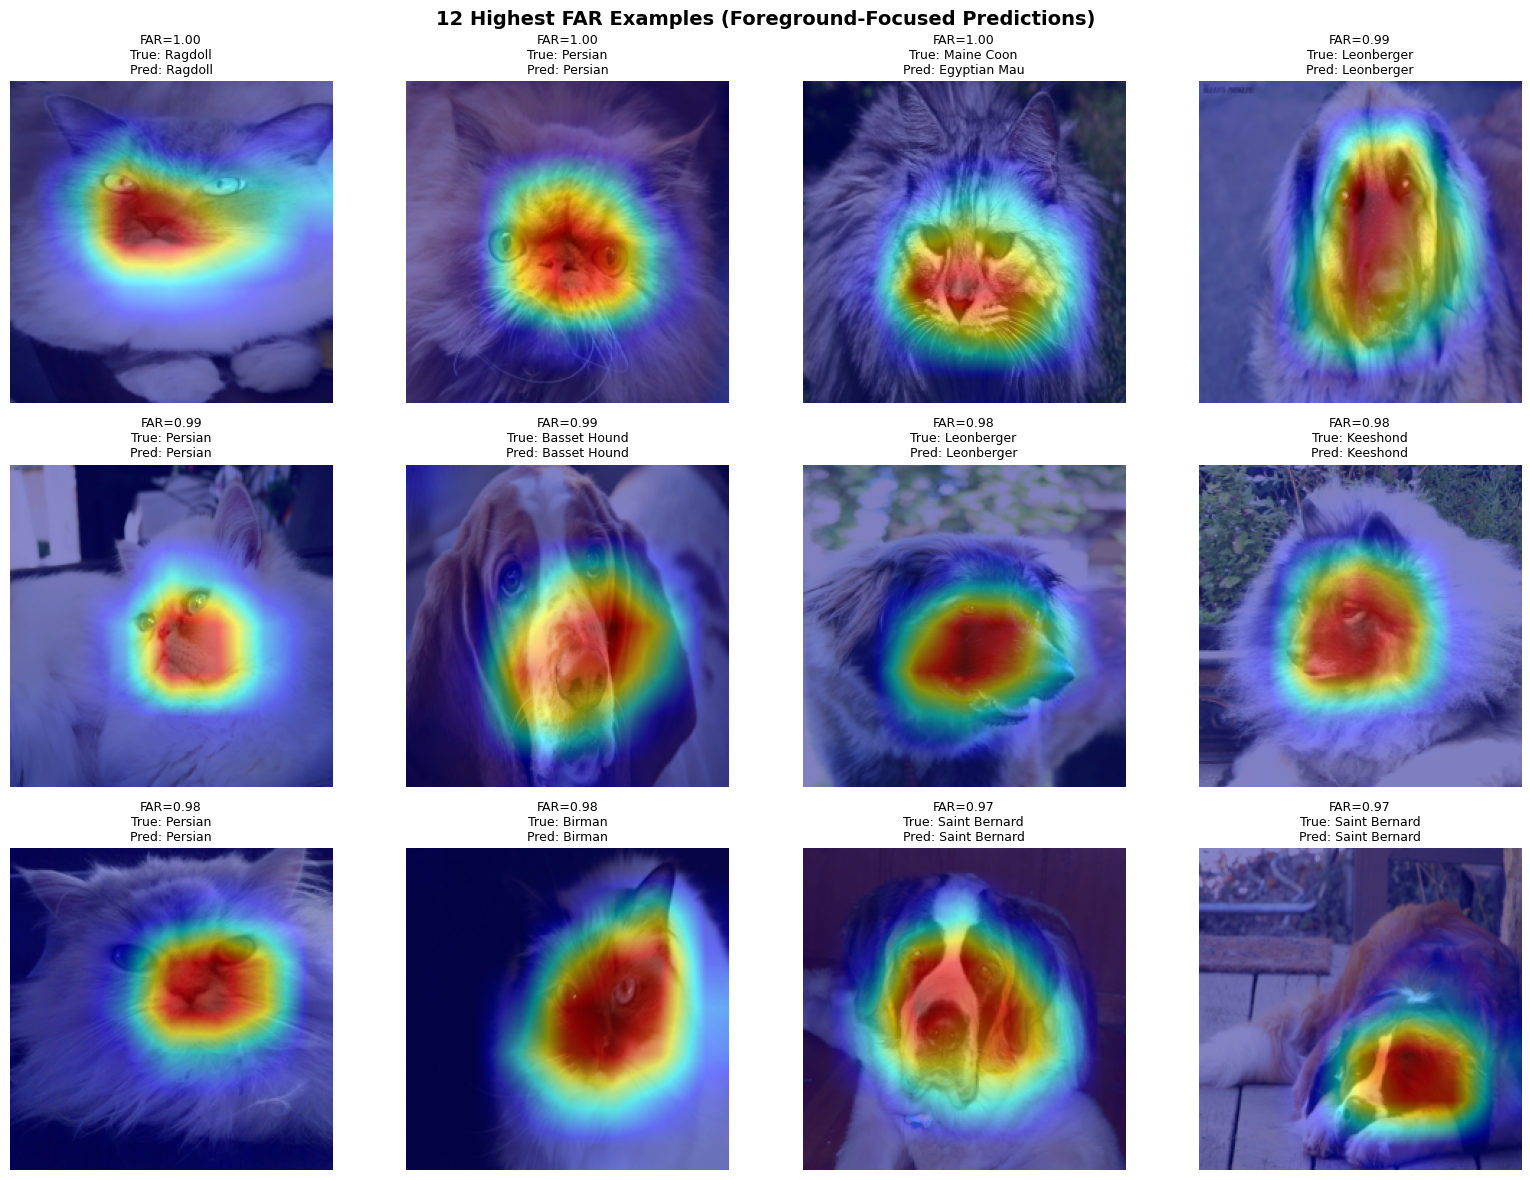

✓ High FAR gallery saved


In [18]:
# Gallery: 12 BEST examples (highest FAR = most foreground-focused)
print("Creating gallery of HIGH FAR examples (correct model behavior)...")

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(12):
    e = sorted_examples[-(i+1)]  # Get from end (highest FAR)
    cam_vis = show_cam_on_image(e['image'], e['cam'], use_rgb=True)
    
    axes[i].imshow(cam_vis)
    axes[i].set_title(
        f"FAR={e['far']:.2f}\n"
        f"True: {e['true_class']}\n"
        f"Pred: {e['pred_class']}",
        fontsize=9
    )
    axes[i].axis('off')

plt.suptitle('12 Highest FAR Examples (Foreground-Focused Predictions)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{output_dir}/high_far_gallery.png", dpi=150)
plt.show()

print("✓ High FAR gallery saved")


In [19]:
# Save all results to CSV
results_df = pd.DataFrame([
    {
        'val_idx': e['idx'],
        'true_class': e['true_class'],
        'pred_class': e['pred_class'],
        'correct': e['correct'],
        'far': e['far']
    }
    for e in examples
])

results_path = f"{output_dir}/far_all_results.csv"
results_df.to_csv(results_path, index=False)

print(f"✓ Complete FAR results saved: {results_path}")
print(f"  Total samples: {len(results_df)}")
print(f"  Accuracy: {results_df['correct'].mean()*100:.2f}%")
print(f"  Mean FAR: {results_df['far'].mean():.3f}")


✓ Complete FAR results saved: ../experiments/results/gradcam/baseline/far_all_results.csv
  Total samples: 736
  Accuracy: 92.39%
  Mean FAR: 0.666


In [20]:
import os
import json
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd

# Load model
model.eval()  # Already loaded from Day 4
device = torch.device(CONFIG['device'])

# Load counterfactual metadata
with open('../data/counterfactuals/val_counterfactual/metadata.json', 'r') as f:
    cf_metadata = json.load(f)

print(f"Loaded {len(cf_metadata)} counterfactual samples")

# Evaluate on ORIGINAL images
print("\n" + "="*60)
print("EVALUATING ON ORIGINAL IMAGES")
print("="*60)

correct_original = 0
predictions_original = []

for idx, sample in enumerate(tqdm(val_dataset)):
    image = sample['image'].unsqueeze(0).to(device)
    label = sample['label']
    
    with torch.no_grad():
        output = model(image)
        pred = output.argmax(dim=1).item()
    
    if pred == label:
        correct_original += 1
    
    predictions_original.append({
        'val_idx': idx,
        'true_label': label,
        'pred_label': pred,
        'correct': pred == label
    })

acc_original = correct_original / len(val_dataset)
print(f"\nOriginal Accuracy: {acc_original*100:.2f}%")


Loaded 736 counterfactual samples

EVALUATING ON ORIGINAL IMAGES


100%|███████████████████████████████████████████████████████████████████| 736/736 [00:17<00:00, 41.00it/s]


Original Accuracy: 92.39%


In [21]:
# Evaluate on COUNTERFACTUAL images
print("\n" + "="*60)
print("EVALUATING ON COUNTERFACTUAL IMAGES")
print("="*60)

correct_counterfactual = 0
predictions_counterfactual = []

cf_image_dir = '../data/counterfactuals/val_counterfactual/images'

for idx, cf_info in enumerate(tqdm(cf_metadata)):
    cf_path = os.path.join(cf_image_dir, f"counterfactual_{idx:04d}.jpg")
    
    # Load counterfactual image
    cf_image = Image.open(cf_path).convert('RGB')
    cf_image = np.array(cf_image) / 255.0
    
    # Transform same way as original
    cf_tensor = torch.tensor(cf_image.transpose(2, 0, 1)).float()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    cf_tensor = (cf_tensor - mean) / std
    cf_tensor = cf_tensor.unsqueeze(0).to(device)
    
    # Get label (same as original)
    true_label = cf_info['label']
    
    # Predict
    with torch.no_grad():
        output = model(cf_tensor)
        pred = output.argmax(dim=1).item()
    
    if pred == true_label:
        correct_counterfactual += 1
    
    predictions_counterfactual.append({
        'cf_idx': idx,
        'true_label': true_label,
        'pred_label': pred,
        'correct': pred == true_label
    })

acc_counterfactual = correct_counterfactual / len(cf_metadata)
print(f"\nCounterfactual Accuracy: {acc_counterfactual*100:.2f}%")



EVALUATING ON COUNTERFACTUAL IMAGES


100%|███████████████████████████████████████████████████████████████████| 736/736 [00:09<00:00, 74.56it/s]


Counterfactual Accuracy: 63.32%


In [22]:
# Compute ∆Acc (the CRITICAL METRIC!)
delta_acc = acc_original - acc_counterfactual

print("\n" + "="*60)
print("ACCURACY DROP ON COUNTERFACTUALS (∆Acc)")
print("="*60)
print(f"\nOriginal Accuracy:        {acc_original*100:.2f}%")
print(f"Counterfactual Accuracy:  {acc_counterfactual*100:.2f}%")
print(f"∆Acc (drop):              {delta_acc*100:.2f}%")

# Interpretation
print("\nINTERPRETATION:")
if delta_acc > 0.20:  # More than 20% drop
    print(f"⚠️  SEVERE background dependence!")
    print(f"   Model accuracy DROPS {delta_acc*100:.1f}% when background changes")
    print(f"   This PROVES background is a spurious cue")
elif delta_acc > 0.10:
    print(f"⚠️  Moderate background dependence")
    print(f"   Accuracy drops {delta_acc*100:.1f}% on counterfactuals")
elif delta_acc > 0.05:
    print(f"✓  Slight background dependence")
    print(f"   Accuracy drops only {delta_acc*100:.1f}% on counterfactuals")
else:
    print(f"✓  Minimal background dependence")
    print(f"   Accuracy drops only {delta_acc*100:.1f}% on counterfactuals")
    print(f"   Model is ROBUST to background changes!")



ACCURACY DROP ON COUNTERFACTUALS (∆Acc)

Original Accuracy:        92.39%
Counterfactual Accuracy:  63.32%
∆Acc (drop):              29.08%

INTERPRETATION:
⚠️  SEVERE background dependence!
   Model accuracy DROPS 29.1% when background changes
   This PROVES background is a spurious cue


In [23]:
# Per-class accuracy drop
print("\n" + "="*60)
print("PER-CLASS ACCURACY DROP")
print("="*60)

per_class_original = {}
per_class_counterfactual = {}

# Original
for pred in predictions_original:
    cls = pred['true_label']
    if cls not in per_class_original:
        per_class_original[cls] = {'correct': 0, 'total': 0}
    per_class_original[cls]['total'] += 1
    if pred['correct']:
        per_class_original[cls]['correct'] += 1

# Counterfactual
for pred in predictions_counterfactual:
    cls = pred['true_label']
    if cls not in per_class_counterfactual:
        per_class_counterfactual[cls] = {'correct': 0, 'total': 0}
    per_class_counterfactual[cls]['total'] += 1
    if pred['correct']:
        per_class_counterfactual[cls]['correct'] += 1

# Compute per-class ∆Acc
per_class_delta = []
for cls_idx in per_class_original.keys():
    acc_orig = per_class_original[cls_idx]['correct'] / per_class_original[cls_idx]['total']
    acc_cf = per_class_counterfactual.get(cls_idx, {'correct': 0, 'total': 0})['correct'] / max(1, per_class_counterfactual.get(cls_idx, {'total': 1})['total'])
    delta = acc_orig - acc_cf
    
    per_class_delta.append({
        'class': dataset.classes[cls_idx],
        'acc_original': acc_orig,
        'acc_counterfactual': acc_cf,
        'delta_acc': delta,
        'drop_percent': delta * 100
    })

# Sort by largest drop
per_class_delta.sort(key=lambda x: x['delta_acc'], reverse=True)

print("\nTop 10 Classes with LARGEST Accuracy Drop (most background-dependent):")
for i, row in enumerate(per_class_delta[:10]):
    print(f"{i+1}. {row['class']:20s}: {row['acc_original']*100:5.1f}% → {row['acc_counterfactual']*100:5.1f}% (∆Acc: {row['drop_percent']:+6.1f}%)")

print("\nTop 10 Classes with SMALLEST Accuracy Drop (most robust):")
for i, row in enumerate(per_class_delta[-10:]):
    print(f"{i+1}. {row['class']:20s}: {row['acc_original']*100:5.1f}% → {row['acc_counterfactual']*100:5.1f}% (∆Acc: {row['drop_percent']:+6.1f}%)")

# Save to CSV
df_per_class = pd.DataFrame(per_class_delta)
df_per_class.to_csv('../experiments/results/metrics/per_class_accuracy_drop.csv', index=False)
print(f"\n✓ Per-class analysis saved")



PER-CLASS ACCURACY DROP

Top 10 Classes with LARGEST Accuracy Drop (most background-dependent):
1. Staffordshire Bull Terrier:  87.5% →   0.0% (∆Acc:  +87.5%)
2. American Bulldog    :  95.5% →  13.6% (∆Acc:  +81.8%)
3. English Setter      :  93.3% →  20.0% (∆Acc:  +73.3%)
4. Basset Hound        :  92.3% →  23.1% (∆Acc:  +69.2%)
5. Russian Blue        :  86.4% →  22.7% (∆Acc:  +63.6%)
6. American Pit Bull Terrier:  76.5% →  17.6% (∆Acc:  +58.8%)
7. German Shorthaired  :  68.8% →  12.5% (∆Acc:  +56.2%)
8. Boxer               :  90.9% →  40.9% (∆Acc:  +50.0%)
9. Abyssinian          :  94.4% →  50.0% (∆Acc:  +44.4%)
10. Siamese             : 100.0% →  55.6% (∆Acc:  +44.4%)

Top 10 Classes with SMALLEST Accuracy Drop (most robust):
1. Maine Coon          :  87.5% →  79.2% (∆Acc:   +8.3%)
2. Japanese Chin       :  96.6% →  89.7% (∆Acc:   +6.9%)
3. Pomeranian          : 100.0% →  94.1% (∆Acc:   +5.9%)
4. Havanese            : 100.0% →  94.4% (∆Acc:   +5.6%)
5. Pug                 : 100.0% → 

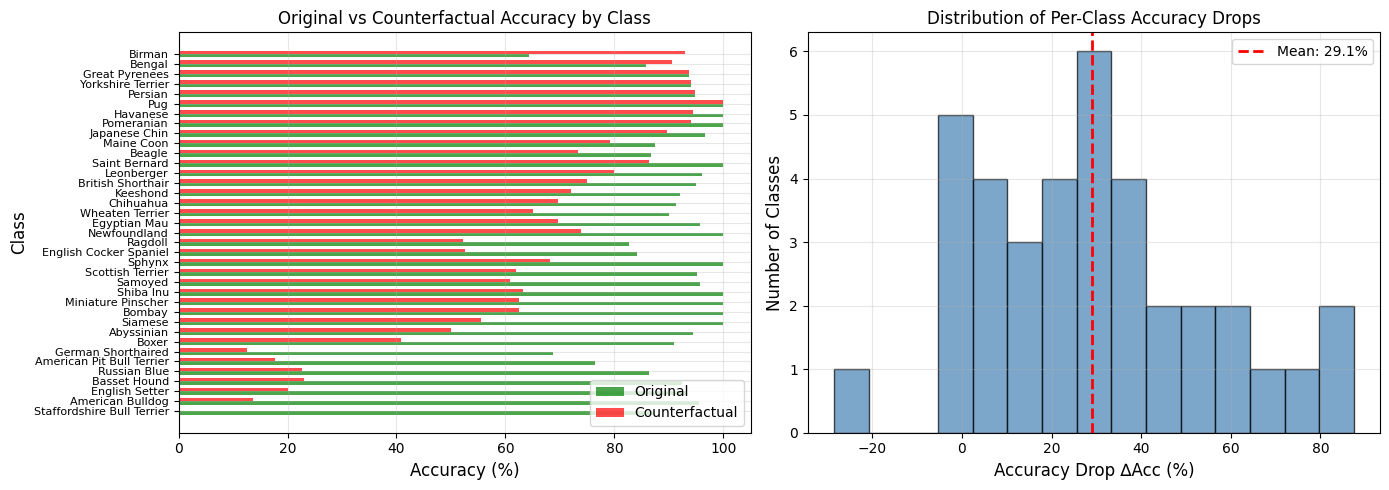

✓ Comparison visualization saved


In [24]:
import matplotlib.pyplot as plt

# Visualization: Accuracy comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Original vs Counterfactual accuracy by class
classes = [row['class'] for row in per_class_delta]
acc_orig = [row['acc_original']*100 for row in per_class_delta]
acc_cf = [row['acc_counterfactual']*100 for row in per_class_delta]

x = np.arange(len(classes))
width = 0.35

axes[0].barh(x - width/2, acc_orig, width, label='Original', color='green', alpha=0.7)
axes[0].barh(x + width/2, acc_cf, width, label='Counterfactual', color='red', alpha=0.7)
axes[0].set_xlabel('Accuracy (%)', fontsize=12)
axes[0].set_ylabel('Class', fontsize=12)
axes[0].set_yticks(x)
axes[0].set_yticklabels(classes, fontsize=8)
axes[0].legend()
axes[0].set_title('Original vs Counterfactual Accuracy by Class', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Histogram: ∆Acc distribution
delta_accs = [row['drop_percent'] for row in per_class_delta]
axes[1].hist(delta_accs, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(delta_acc*100, color='red', linestyle='--', linewidth=2, label=f'Mean: {delta_acc*100:.1f}%')
axes[1].set_xlabel('Accuracy Drop ∆Acc (%)', fontsize=12)
axes[1].set_ylabel('Number of Classes', fontsize=12)
axes[1].set_title('Distribution of Per-Class Accuracy Drops', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/results/metrics/accuracy_drop_comparison.png', dpi=150)
plt.show()

print("✓ Comparison visualization saved")


In [28]:

summary = f"""
BASELINE MODEL ROBUSTNESS ANALYSIS:

Original Validation Set:    {acc_original*100:.2f}% ({correct_original}/{len(val_dataset)})
Counterfactual Set:         {acc_counterfactual*100:.2f}% ({correct_counterfactual}/{len(cf_metadata)})
Accuracy Drop (∆Acc):       {delta_acc*100:.2f}%

INTERPRETATION:
"""

if delta_acc > 0.20:
    summary += f"""
⚠️  SIGNIFICANT BACKGROUND DEPENDENCE DETECTED!
    - Model relies heavily on background cues
    - Accuracy drops {delta_acc*100:.1f}% when backgrounds are swapped
    - This PROVES spurious correlations exist
    - Mitigation strategies (BR, CBF) will be effective
"""
elif delta_acc > 0.10:
    summary += f"""
⚠️  MODERATE BACKGROUND DEPENDENCE
    - Model shows some background reliance
    - Accuracy drops {delta_acc*100:.1f}% on counterfactuals
    - Background is a contributing cue
"""
elif delta_acc > 0.05:
    summary += f"""
✓  MILD BACKGROUND DEPENDENCE
    - Model is reasonably robust
    - Accuracy drops only {delta_acc*100:.1f}%
    - Room for improvement with mitigation
"""
else:
    summary += f"""
✓  MODEL IS ROBUST TO BACKGROUND CHANGES
    - Minimal background dependence ({delta_acc*100:.1f}%)
    - Model primarily uses foreground features
    - High FAR (0.666) and low ∆Acc are BOTH GOOD signs
"""

summary += f"""
PER-CLASS ANALYSIS:
    Most background-dependent: {per_class_delta[0]['class']} (∆Acc: {per_class_delta[0]['drop_percent']:+.1f}%)
    Most robust: {per_class_delta[-1]['class']} (∆Acc: {per_class_delta[-1]['drop_percent']:+.1f}%)
    
FILES CREATED:
    ✓ Per-class accuracy drop CSV
    ✓ Accuracy comparison visualizations
    ✓ Original vs Counterfactual predictions
"""
print(summary)




BASELINE MODEL ROBUSTNESS ANALYSIS:

Original Validation Set:    92.39% (680/736)
Counterfactual Set:         63.32% (466/736)
Accuracy Drop (∆Acc):       29.08%

INTERPRETATION:

⚠️  SIGNIFICANT BACKGROUND DEPENDENCE DETECTED!
    - Model relies heavily on background cues
    - Accuracy drops 29.1% when backgrounds are swapped
    - This PROVES spurious correlations exist
    - Mitigation strategies (BR, CBF) will be effective

PER-CLASS ANALYSIS:
    Most background-dependent: Staffordshire Bull Terrier (∆Acc: +87.5%)
    Most robust: Birman (∆Acc: -28.6%)

FILES CREATED:
    ✓ Per-class accuracy drop CSV
    ✓ Accuracy comparison visualizations
    ✓ Original vs Counterfactual predictions

